<h1>Multi-step Time Series Forecasting with Long Short-Term Memory Networks in Python</h1><br>
https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

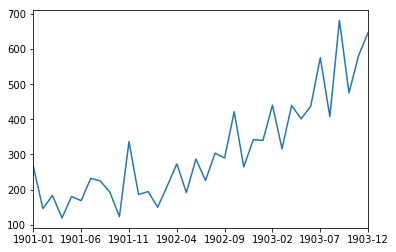

In [102]:
import sys
# add util lib path
sys.path.append('../util')

import pandas as pd
from pandas import datetime
from matplotlib import pyplot
import ts_input  as ui   # user-defined lib
from pandas import DataFrame
shampoo_input = '../input/sales-of-shampoo-over-a-three-ye.csv'
series = ui.load_series_data(shampoo_input)

def convert_to_datestring(idx):
    dt = []
    for i in idx:
        s_date = "190" + str(i[3]) + str(i[4:7])
        dt.append(s_date)
        #print(date)
    return dt

dt = convert_to_datestring(series.index)
#print(dt)
#DatetimeIndex.strftime(date_format
series.index = dt
series.plot()
pyplot.show()



In [103]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
 

In [104]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [105]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [106]:
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values),1)
    # rescale values to -1,1
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values),1)
    # transfrom into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [107]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    # X = X.reshape(X.shape[0], 1, X.shape[1])
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2])))
    model.add(Dense(y.shape[1])) # 3 outputs
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False) # stateful
        model.reset_states()
    return model

The same batch size must be used for training and predictiion, and we require predictions to be made at each time step of the test dataset. This means that a batch size of 1 must be used. A batch size of 1 is also called online learning as the network weights will be updated during training after each training pattern

In [108]:
# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [109]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts

We can invert the differencing by adding the value of the last observation (prior months' shampoo sales) to the first forecasted value, then propagating the value down the forecast. This is a little fiddly;we can wrap up the behavior in a function name inverse_difference() that takes the last observed value prior to the forecast and the forecast as arguments and returns the inverted forecast.

In [110]:
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [111]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i -1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [112]:
import math
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = math.sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [113]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i -1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [114]:
n_lag = 1
n_seq = 4
n_test = 10
n_epochs = 50 # 1500
n_batch = 1
n_neurons = 1


In [115]:
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

In [116]:
train.shape # train.shape 22, 4

(21, 5)

In [117]:
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

In [118]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (1, 1)                    12        
_________________________________________________________________
dense_8 (Dense)              (1, 4)                    8         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [119]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

In [120]:
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)

t+1 RMSE: 96.250490
t+2 RMSE: 78.069503
t+3 RMSE: 106.199096
t+4 RMSE: 99.594564


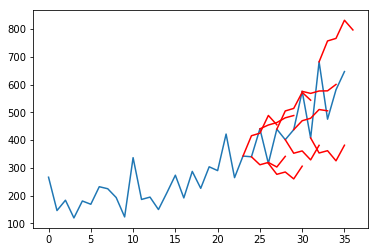

In [121]:
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
plot_forecasts(series, forecasts, n_test+2)
#t+1 RMSE: 145.967480
#t+2 RMSE: 83.509823
#t+3 RMSE: 113.121878